In [1]:
n_threads = 6

In [2]:
import os
if n_threads is not None:
    os.environ["OMP_NUM_THREADS"] = str(n_threads)

sampling points for x emittance
Runtime: 4.179588261991739
sampling points for y emittance
Runtime: 5.166956543922424
creating emittance fit x
Runtime: 0.9443871136754751
creating emittance fit y
Runtime: 0.6993272937834263
total time: 11.185721008107066


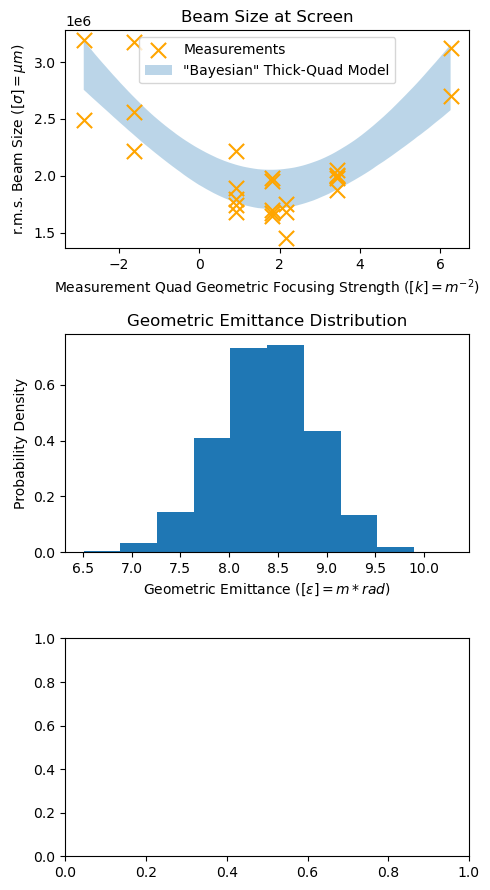

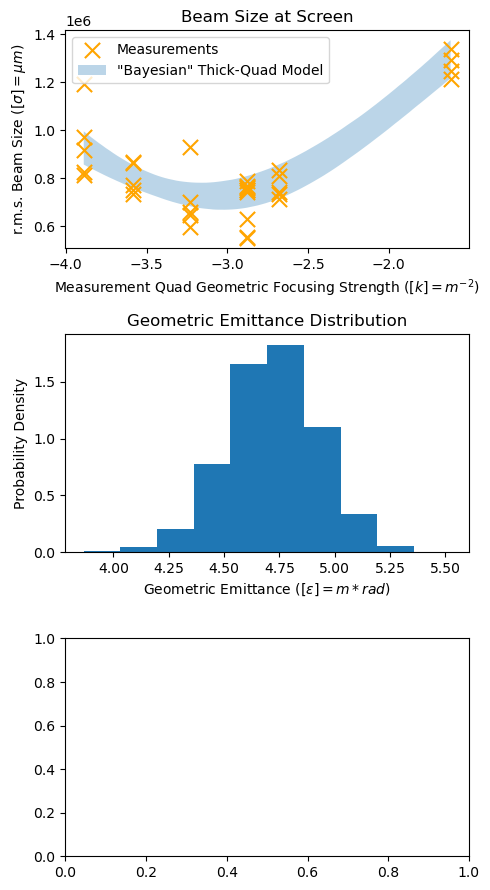

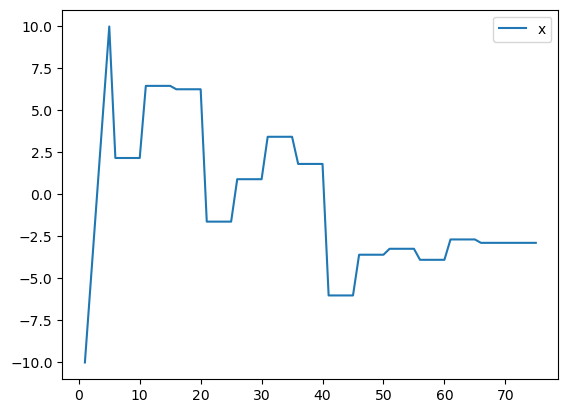

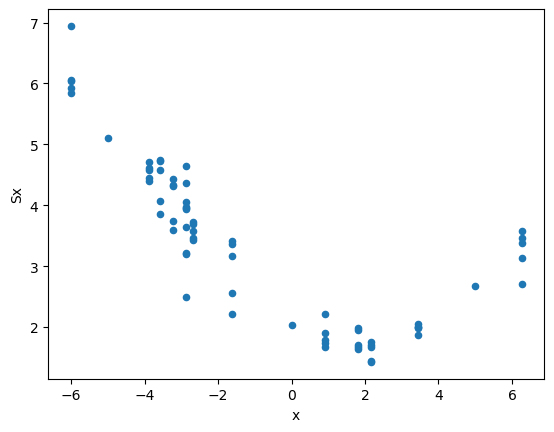

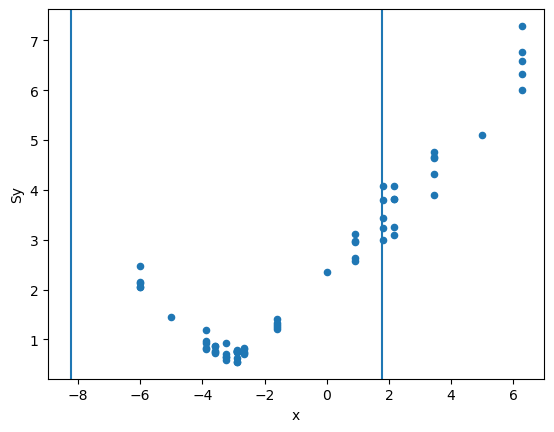

In [3]:
import sys
from time import perf_counter
from copy import deepcopy
sys.path.append("../")

import warnings
warnings.simplefilter("ignore")


from xopt import VOCS
from scripts.automatic_emittance import BaseEmittanceMeasurement, BeamlineConfig
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def test_beamsize_function(inputs):
    x = inputs["x"]
    n = inputs.pop("n",5)
    y = x + 6

    # simulate greater uncertainty for single shot measurements
    if n == 1:
        noise = 0.1
    else:
        noise = 0.1

    sx = np.sqrt(0.5*x**2 - 2*x + 5) * (1.0 + np.random.randn(n) * noise)
    sy = np.sqrt(0.5*y**2 - 3*y + 5) * (1.0 + np.random.randn(n) * noise)

    c = 0.25*x**2 - 10
    if c > 0:
        sx = sx * np.NaN
        sy = sy * np.NaN

    total_size = np.sqrt(np.array(sx) ** 2 + np.array(sy) ** 2)

    return {"Sx": sx, "Sy": sy, "total_size": total_size, "c":c}


class TAutomaticEmittanceMeasurement(BaseEmittanceMeasurement):
    def eval_beamsize(self, inputs):
        results = test_beamsize_function(inputs)
        results["S_x_mm"] = results["Sx"]
        results["S_y_mm"] = results["Sy"]
        return results


    @property
    def base_vocs(self):
        vocs = VOCS(
            variables={
                self.beamline_config.scan_quad_pv: self.beamline_config.scan_quad_range
            },
            constraints={"c": ["LESS_THAN",0]},
            observables=["S_x_mm", "S_y_mm"],
        )

        return vocs

    @property
    def x_measurement_vocs(self):
        vocs = deepcopy(self.base_vocs) 
        vocs.objectives={"S_x_mm":"MINIMIZE"}
        #vocs.constraints={"S_x_mm": ["LESS_THAN", 5]}

        return vocs

    @property
    def y_measurement_vocs(self):
        vocs = deepcopy(self.base_vocs)  
        vocs.objectives={"S_y_mm":"MINIMIZE"}
        #vocs.constraints={"S_y_mm": ["LESS_THAN", 5]}

        return vocs

    def get_initial_data(self):
        grid = np.linspace(*self.x_measurement_vocs.bounds,5).flatten()
        result = [{"x":[ele]} | self.eval_beamsize({"x":ele,"n":1}) for ele in grid]

        def delist(x):
            try:
                return x[0]
            except Exception:
                return x
        
        result = pd.DataFrame(result).applymap(delist)
        return result
        #return self.x_measurement_vocs.random_inputs(5)

 
beamline_config = BeamlineConfig(
    scan_quad_pv="x",
    scan_quad_range=[-10, 10],
    scan_quad_length=0.1,
    transport_matrix_x=[[1.0, 1.0], [0.0, 1.0]],
    transport_matrix_y=[[1.0, 1.0], [0.0, 1.0]],
    beam_energy=1.0,
)

emittance_measurement = TAutomaticEmittanceMeasurement(
    beamline_config=beamline_config,
    n_iterations=7,
    turbo_length=0.5,
    visualize=1,
)

start=perf_counter()
results, emit_x = emittance_measurement.run()
print("total time: " + str(perf_counter() - start))

emit_x.data.plot(y="x")
ax = emit_x.data.plot.scatter(x="x", y="Sx")
ax = emit_x.data.plot.scatter(x="x", y="Sy")
tr = emit_x.generator.turbo_controller.get_trust_region(
    emit_x.generator.model
).flatten()
for ele in tr:
    ax.axvline(ele)

emit_x.data.to_csv("test_data.csv")

os.remove(emittance_measurement.dump_file)
plt.show()